## <font color=darkblue>Implémentation du maximum de vraisemblance pour le modèle de régression logistique</font>

L'objectif de la régression logistique est d'expliquer une variable binaire par des observations réelles indépendantes. Pour y parvenir on estime le paramètre inconnu qui lie les observations et la variable binaire. On se place donc dans un cadre paramétrique. Commençons par détailler le modèle de régression logistique.

# Sommaire
* [1. Le modèle](#modele)
* [2. Maximisation de la vraisemblance](#lm)
    * [2.1. Méthode du 1er ordre : montée de gradient](#gradient)
    * [2.2. Méthode du 2nd ordre : Newton-Raphson](#nr)
    * [2.3. Exemple non logistique](#eg)
* [3. Conclusion et ouvertures](#conclusion)

# <font color=darkgreen>1. Le modèle</font><a id='modele'></a>

La régression logistique appartient à une classe de modèles dits de classification supervisée. Donnons en une définition formelle.

**Définition** Le `modèle de classification supervisée` correspond à la donnée de $\mathcal{D}_n = (X_i,Y_i)_{1\leq i\leq n}$ les observations où $(X_i,Y_i) \stackrel{iid}{\sim} (X,Y)$ un couple générique de loi $P_{X,Y}$ où $X \in \mathbb{R}^d$ est la variable dite explicative (de dimension $d \in \mathbb{N}$), et $Y \in \{ 0,1 \}$ est la variable expliquée.

Naturellement, après avoir observé des données ET leurs étiquettes, on aimerait pouvoir faire des prédictions. Sur quelle quantité concentrer nos efforts ? Sur ce qu'on peut espérer de la variable expliquée sachant la variable explicative.

**Définition** On appelle `fonction de régression` la fonction
$$
    \eta : x \in \mathbb{R}^d \mapsto \eta(x) = \mathbb{E}[Y|X=x]
$$

Dans notre cas, $\eta(x) = \mathbb{E}[Y|X=x] = P(Y=1|X=x)$

Puisque la loi du couple générique $(X,Y)$ est inconnue, nous ferons comme d'habitude en statistique : un estimateur.

Précisons maintenant le cadre de la régression logistique qui consiste simplement en l'ajout d'une hypothèse.

**Définition** Le `modèle de régression logistique` correspond à un modèle de classification supervisée sur lequel on fait l'`hypothèse logistique` : $\exists \beta \in \mathbb{R}^d, \exists a \in \mathbb{R}, \forall x \in \mathbb{R}^d$,
$$
    log\left( \frac{\eta(x)}{1-\eta(x)} \right) = \beta^Tx+a
$$

**Il est important de remarquer que** $1 - \eta(x) = P(Y=0|X=x)$ donc
$ P(Y=1|X=x) \geq P(Y=0|X=x) \iff log\left( \frac{\eta(x)}{1-\eta(x)} \right) \geq 0 $.\
Par conséquent, 
$$\boxed{\beta^Tx+a \geq 0 \implies \text{Y=1 est plus probable que Y=0}}$$

Il nous suffit donc d'estimer les deux paramètres $\beta$ et $a$. Exprimons la vraisemblance du modèle.

Puisque $\eta(x) = \frac{exp(\beta^Tx+a)}{1+exp\beta^Tx+a)}$, on a $\mathcal{L}((Y_i)_{1\leq i\leq n} | (X_i)_{1\leq i\leq n}) = \bigotimes_{i=1}^n \mathcal{B}(\eta(X_i)) = \bigotimes_{i=1}^n \mathcal{B}\left(\frac{exp(\beta^TX_i+a)}{1+exp(\beta^TX_i+a)}\right)$

>**Rappel** : si les $(X_i)_{1\leq i\leq n}$ sont indépendants à valeurs dans $(X,\mathcal{X})$ muni d'une mesure de référence $\mu$, et que la loi de $X_1$ a une densité $p_{\theta_0}$ par rapport à $\mu$ où $p_{\theta_0} \in \left\{ p_{\theta}, \theta \in \Theta \right\}$, par indépendance des $X_i$, la fonction de `vraisemblance` s'écrit alors
$$L_n : \theta \mapsto p_{\theta}(X_1,...,X_n) = \prod_{i=1}^{n}p_{\theta}(X_i)
$$
Et la `log-vraisemblance`
$$
l_n : \theta \mapsto log(p_{\theta}(X_1,...,X_n)) = \sum_{i=1}^{n}log(p_{\theta}(X_i))
$$
On appelle `maximum de vraisemlance` tout $\hat{\theta}_n^{MV}$ tel que
$$
    \hat{\theta}_n^{MV} \in \underset{\theta \in \Theta}{\mathrm{argmax}}\:L_n(\theta)
$$

Puisque la densité d'une $\mathcal{B}(p)$ peut s'écrire comme $x \in \{0,1\} \mapsto p^x(1-p)^{1-x}$ et que les données sont indépendantes, la vraisemblance s'écrit
$$
    \prod_{i=1}^n
    \left(     \frac{exp(\beta^TX_i+a)}{1+exp(\beta^TX_i+a)} \right)^{Y_i}
    \left( 1 - \frac{exp(\beta^TX_i+a)}{1+exp(\beta^TX_i+a)} \right)^{1 - Y_i}
$$

Finalement on obtient la log-vraisemblance du modèle logistique
<font color=darkred>
    $$l_n(\beta,a) = \sum_{i=1}^n \left( Y_i\left(\beta^TX_i+a\right) - log\left(1+e^{\beta^TX_i+a}\right) \right)$$
</font>

Une fois qu'on a estimé $\beta$ et $a$ par $\hat{\beta}$ et $\hat{a}$ en maximisant cette vraisemblance, on obtient l'estimateur plug-in du classifieur $h(x) = \mathbb{1}\left\{ \eta(x) \geq \frac{1}{2} \right\}$ (dit de Bayes) :
<font color=darkred>
    $$\hat{h}(x) = \mathbb{1}\left\{ \hat{\beta}^Tx + \hat{a} \geq 0 \right\}$$
</font>

**La question est maintenant de savoir comment maximiser cette vraisemblance**. En effet la tâche n'est pas simple car son maximum n'est pas explicitement calculable. Ainsi l'objectif de ce notebook est de voir deux méthodes qui nous permettent de contourner ce problème. Nous commençerons par la célèbre méthode de gradient, puis nous verrons une méthode du 2nd ordre : Newton-Raphson.

# <font color=darkgreen>2. Maximisation de la vraisemblance</font></font><a id='lm'></a>

## 2.1. Méthode du 1er ordre : montée de gradient</font><a id='gradient'></a>

Cette méthode part de l'idée intuitive que pour atteindre le maximum il faut monter, or c'est le gradient qui nous indique la route à prendre pour monter le plus. En considérant que $\theta = (a, \beta)$ est le paramètre recherché, on produit une suite $\left\{ \hat{\theta}^{(K)} \right\}_{K\geq0}$ d'estimateurs de $\theta$. L'algorithme est le suivant :\
`Initialisation :` $\hat{\theta}^{(0)}$ est choisi arbitrairement\
`Itérations :` $\forall K \geq 0, \hat{\theta}^{(K+1)} = \hat{\theta}^{(K)} + \eta_{K+1}\nabla_{\theta}l_n\left(\hat{\theta}^{(K)}\right)$\
où les $\left(\eta_K\right)_{K\geq1}$ sont des pas dans $\mathbb{R}_+^*$.

Plusieurs critères d'arrêts sont possibles et peuvent être combinés. On peut par exemple citer :
- lorsque le gradient de $l_n$ est suffisamment petit : $\| \nabla_{\theta}l_n\left(\hat{\theta}^{(K)}\right) \| \leq \varepsilon$
- lorsque les itérés ne progressent plus suffisamment : $\|\hat{\theta}^{(K+1)} - \hat{\theta}^{(K)}\| \leq \varepsilon$
- lorsque les valeurs de $l_n$ ne changent plus suffisamment : $\|l_n\left(\hat{\theta}^{(K+1)}\right) - l_n\left(\hat{\theta}^{(K)}\right)\| \leq \varepsilon$

En plus de ces critères on peut ajouter une condition sur un nombre d'itérations maximum à ne pas dépasser.

**Remarque importante** : le théorème de convergence de la méthode de gradient fait une hypothèse sur le pas : le pas doit être compris entre $0$ et $2/M$ avec la fonction à maximiser de gradient $M$-Lipschitz.

>**Conventions de code**\
Nous prenons pour convention que les matrices de données sont de taille $d$ x $size$ où $d$ correspond à la dimension d'une donnée et $size$ au nombre total de données. Autrement dit, une colonne correspond à une donnée.\
Les paramètres $a$ et $\beta$ sont passés sous la forme d'un tableau à $d+1$ éléments : $\theta$ = \[$a$, $\beta_1$, ..., $\beta_d$\]. Nous écrirons donc a = theta\[0\] et beta = theta\[1:d\].

Voici le code Python implémentant cette méthode :

In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import autograd.numpy as np
import autograd
from autograd import grad, jacobian
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from math import *
sns.set_theme()
rng = default_rng()

In [2]:
# LOGISTIC REGRESSION LIKELIHOOD FUNCTION
def get_loglikelihood(X,Y):
    """
    Inputs
    ----------
    X,Y: data. X of dimension d x size. Y of dimension size

    Outputs
    -------
    function loglikelihood : theta -> loglikelihood(theta)
    """
    def loglikelihood(theta):
        """
        Inputs
        ----------
        theta = [a, beta_1, ..., beta_d]

        Outputs
        -------
        loglikelihood (dimension 1)
        """
        d = len(theta); a = theta[0]; beta = theta[1:d]
        bTXa = np.dot(beta,X) + a
        return np.sum(Y*bTXa - np.log(1 + np.exp(bTXa)))    
    return loglikelihood

In [3]:
# FIXED STEP GRADIENT METHOD
def gradient_met(f, x0, rho, eps, Nmax):
    """
    Inputs
    ----------
    f: the function we want to maximize
    x0: the initialization (dimension d+1)
    rho: the step
    eps: the precision (stop criteria)
    Nmax: the maximum number of iterations
    
    Outputs
    -------
    x: the minimum (dimension d+1)
    n: the number of iterations
    cv: a boolean that indicates if the algorithm has converged
    iterations: array of the iterations
    f_iterations: array of the iterations of f
    """
    grad_f = autograd.grad(f)
    n = 0
    x = x0
    gfx = grad_f(x)
    iterations = [x]
    f_iterations = [f(x)]
    while(np.linalg.norm(gfx) > eps and n<Nmax):
        x = x + rho*gfx
        gfx = grad_f(x)
        iterations.append(x)
        f_iterations.append(f(x))
        n += 1
    cv = np.linalg.norm(gfx) <= eps
    return x,n,cv, np.array(iterations), np.array(f_iterations)

In [4]:
# REGRESSION FUNCTION
def eta(X,theta):
    """
    Inputs
    ----------
    X: data of shape (d,size)
    theta: (a, beta) of dimension d+1
    
    Outputs
    -------
    eta(X,theta) defined in the text
    """
    d = len(theta); a = theta[0]; beta = theta[1:d]
    exp_bTXa = np.exp(np.dot(beta,X) + a)
    return exp_bTXa / (1 + exp_bTXa)

**Remarque** : pour voir si nos estimateurs sont bons, on a besoin des vrais paramètres. On ne peut donc pas tester notre méthode sur n'importe quelles données. Voici la procédure choisie ici :
- On simule les $X_i$ selon une loi quelconque (ici une loi normale)
- On choisit les vrais paramètres $(a,\beta)$
- On simule les $Y_i$ à partir des $X_i$ et des vrais paramètres $(a,\beta)$ : $Y_i|X_i \sim \mathcal{B}(\eta(X_i))$
- On fait la montée de gradient sur $(X_i,Y_i)_{1\leq i \leq n}$ comme si on ne connaissait pas $(a,\beta)$, ce qui nous donne $(\hat{a},\hat{\beta})$
- On simule d'autres $X_j$ et $Y_j|X_j \sim \mathcal{B}(\eta(X_j))$ de la même façon que les $(X_i,Y_i)$, à partir des vrais paramètres $(a,\beta)$. On regarde pour chaque $X_j$ si $(\hat{a},\hat{\beta})$ prédit correctement $Y_j$

In [5]:
# GENERATE DATA
def generate_data(theta,d,size,sd):
    """
    Inputs
    ----------
    theta: parameter of dimension d+1
    d: dimension
    size: size of the sample
    sd: standard deviation of the sample
    
    Outputs
    -------
    X: data sample
    Y: label of data sample
    X0: sample of label 0
    X1: sample of label 1
    """
    X = np.random.normal(0,sd,(d,size))
    Y = stat.bernoulli.rvs(eta(X,theta)) # split in 2 groups
    X0 = []
    X1 = []
    for i in range(size):
        if Y[i] == 0: X0.append(X[:,i])
        else: X1.append(X[:,i])
    X0 = np.reshape(X0, (len(X0),d))
    X1 = np.reshape(X1, (len(X1),d))
    return X,Y,X0,X1

In [6]:
# SIMULATION OF (X,Y) WITH THE TRUE PARAMETERS
d = 2
theta = np.array([1., 2., 3.]) # a = 1, beta = (2, 3)
size = 500
sd = 10
X,Y,X0,X1 = generate_data(theta,d,size,sd)

In [7]:
# HYPERPLAN TO PLOT CLASSIFIER (SEPARATING Y=0 AND Y=1)
def hyperplan(x, param):
    """
    Inputs
    ----------
    x: vector of dimension d-1
    param: parameters of the hyperplan
    
    Outputs
    -------
    vector of dimension 1 : x_d = -(beta_1.x_1 + ... + beta_(d-1).x_(d-1) + a)/beta_d (because beta^T.X+a=0)
    """
    d = len(param)-1; a = param[0]; beta = param[1:d+1]
    return -(np.dot(beta[0:d-1], x) + a)/beta[d-1]

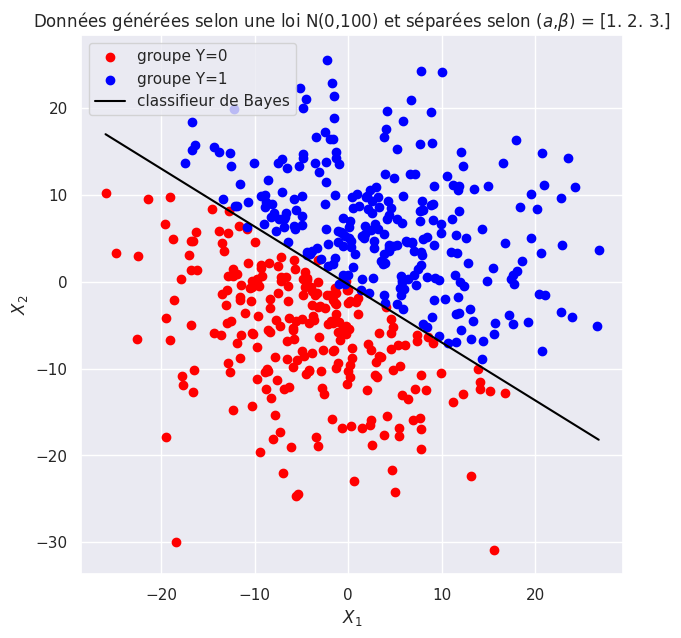

In [8]:
# PLOT A THE DATA
min_x = min(X[0]); max_x = max(X[0])
abscisse = np.linspace(min_x,max_x)
classif_bayes = [hyperplan(x, theta) for x in abscisse]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.scatter(X0[:,0],X0[:,1],label=fr"groupe Y=0", color='red')
ax.scatter(X1[:,0],X1[:,1],label=fr"groupe Y=1", color='blue')
ax.plot(abscisse, classif_bayes, label=fr"classifieur de Bayes", color='black')
ax.set_xlabel("$X_1$"); ax.set_ylabel("$X_2$")
ax.set_title(fr"Données générées selon une loi N(0,{sd**2}) et séparées selon ($a$,$\beta$) = {theta}")
ax.legend()
plt.show()

In [9]:
# RESULT OF THE GRADIENT METHOD
loglikelihood = get_loglikelihood(X,Y)
# Init around the true parameters : x0 = [ a+U[-10,10], beta_1+U[-10,10], ..., beta_d+U[-10,10] ]
x0_grad = np.array([v+20*rng.random()-10 for v in theta])
rho_grad = 0.001 # step
eps_grad = 1 # precision
Nmax_grad = 10000 # max of iteration

theta_grad, nb_iters_grad, cv_grad, iters_grad, l_iters_grad = gradient_met(loglikelihood, 
                                                                            x0_grad, rho_grad, eps_grad, Nmax_grad)

print("True parameters: ", theta)
print("----- Return values of gradient method -----")
print("The maximum of loglikelihood found is ", theta_grad)
print("Found in ", nb_iters_grad, " iterations")
print("Did the method converge ? ", cv_grad)

True parameters:  [1. 2. 3.]
----- Return values of gradient method -----
The maximum of loglikelihood found is  [1.77158932 2.87906904 4.37360349]
Found in  6187  iterations
Did the method converge ?  True


**Remarque** : on peut obtenir des estimateurs très éloignés des vrais paramètres. Ils sont tout de même corrects. En effet on estime à constante multiplicative près puisque $\forall C \in \mathbb{R}_+, C.(\beta^T.X+a) \geq 0 \iff \beta^T.X+a \geq 0$.

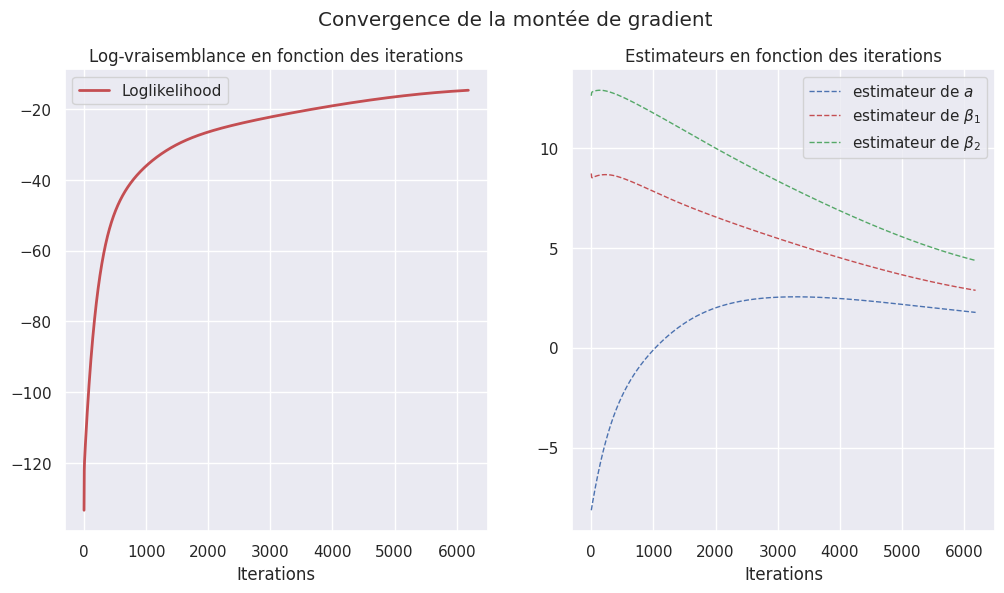

In [10]:
# PLOT OF LOGLIKELIHOOD AND ESTIMATORS VALUES FOR EACH ITERATION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Convergence de la montée de gradient')

ax1.set_title("Log-vraisemblance en fonction des iterations")
ax1.plot(l_iters_grad, 'r-', lw=2, label = 'Loglikelihood');
ax1.set_xlabel("Iterations")
ax1.legend()

ax2.plot(iters_grad[:,0], 'b--', lw=1, label = fr'estimateur de $a$');
ax2.plot(iters_grad[:,1], 'r--', lw=1, label = fr'estimateur de $\beta_1$');
ax2.plot(iters_grad[:,2], 'g--', lw=1, label = fr'estimateur de $\beta_2$');
ax2.set_title('Estimateurs en fonction des iterations')
ax2.set_xlabel("Iterations")
ax2.legend()

plt.show()

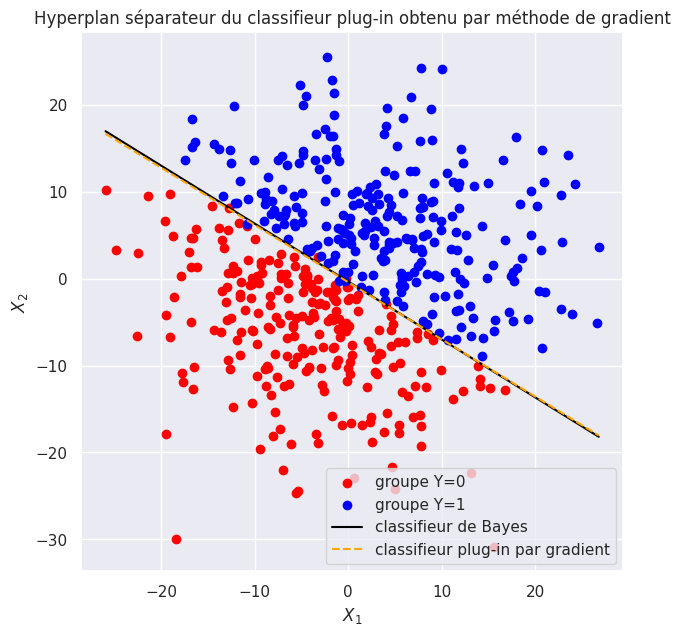

In [11]:
# PLOT OF THE PLUG-IN CLASSIFIER
classif_grad = [hyperplan(x, theta_grad) for x in abscisse]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

ax.scatter(X0[:,0],X0[:,1],label=fr"groupe Y=0", color='red')
ax.scatter(X1[:,0],X1[:,1],label=fr"groupe Y=1", color='blue')
ax.plot(abscisse, classif_bayes, label=fr"classifieur de Bayes", color='black')
ax.plot(abscisse, classif_grad, label=fr"classifieur plug-in par gradient", color='orange', linestyle='dashed')

ax.set_xlabel("$X_1$"); ax.set_ylabel("$X_2$")
ax.set_title("Hyperplan séparateur du classifieur plug-in obtenu par méthode de gradient")

ax.legend()
plt.show()

In [12]:
# PREDICTION GIVEN A X
def predict(x, theta_hat):
    """
    Inputs
    ----------
    x: observed data of dimension d
    theta_hat: estimated parameters [a_hat,beta_hat_1,...,beta_hat_d]
    
    Outputs
    -------
    predicted group of x
    """
    d = len(theta_hat); a_hat = theta_hat[0]; beta_hat = theta_hat[1:d]
    return int(np.dot(beta_hat,x) + a_hat >= 0) # 1 if true, else 0

In [13]:
# TEST OF PREDICTION
def test(nb_tests, theta_hat, theta):
    """
    Inputs
    ----------
    nb_tests: nb of tests
    theta_hat: estimated parameters
    theta : true parameter
    
    Outputs
    -------
    percentage of successful predictions
    """
    X = np.random.normal(0,sd,(d,nb_tests))
    Y = stat.bernoulli.rvs(eta(X,theta))
    pred = [predict(x,theta_hat) for x in X.transpose()]
    return np.sum(pred==Y)/nb_tests

In [14]:
# VALID PREDICTIONS PROPORTION
nb_tests = 1000
mean = test(nb_tests, theta_grad, theta)
print("Mean of successful predictions over ", nb_tests, " tests : ", mean)

Mean of successful predictions over  1000  tests :  0.981


## 2.2. Méthode du 2nd ordre : Newton-Raphson</font><a id='nr'></a>

La méthode de Newton-Raphson est un algorithme itératif du second ordre qui permet d'avoir accès de proche en proche, sous des hypothèses idoines, au zero d'une fonction donnée.
Considérons le cas bien commode de la dimension $d=1$ pour nous en donner l'intuition. 
Pour ce faire, prenons une fonction $f : \mathbb{R} \to \mathbb{R}$ de classe $C^2$ et faisons l'hypothèse que $f$ admet au moins un maximum local sur $\mathbb{R}$, atteint en $x^{*}$.

> On rappelle la condition nécessaire d'optimalité du premier ordre suivante : si E est un espace vectoriel et $f : E \to \mathbb{R}$ différentiable alors, $x^*$ est un maximiseur local de $f$ $\implies df(x^{*})=0$.

Dans notre exemple $f$ est supposée $C^2$ donc différentiable. On peut donc appliquer la proposition précédente et on a $f'(x^*)=0$.
Initialisons un point $x_0$ situé à proximité du maximiseur local.
L'équation de la tangente de $f'$ au point $x_0$  est donnée par $y = f''(x_0)(x-x_0)+f'(x_0).$
On cherche $x_1 \in \mathbb{R}$ tel que $f''(x_0)(x_1-x_0)+f'(x_0)=0$  $\Leftrightarrow$ $x_1=x_0- \frac{f'(x_0)}{f''(x_0)}.$ On détermine ensuite l'équation de la tangente de $f'$ au point $x_1$ et ainsi de suite... avec l'assurance d'une convergence quadratique vers $x^*$ sous certaines hypothèses.
On obtient ainsi l'algorithme itératif de Newton-Raphson donné, en dimension 1, par $\forall k \geq 0$ , $x_{k+1}=x_{k}-\frac{f'(x_k)}{f''(x_k)}$. Tout cela se généralise sans mal pour une fonction $f : \mathbb{R^d} \to \mathbb{R}$ , $d \geq 2$. On obtient l'algortihme itératif suivant :

`Initialisation` : On choisit un point initial $x_0 \in \mathbb{R^d}$.

`Iterations` : $\forall k \geq 0$, on calcule $x_{k+1}=x_{k}-H_f(x_k)^{-1} \nabla f(x_{k})$.

Comme expliqué dans la méthode de gradient, on peut prendre pour critère d'arrêt un nombre maximum d'itérations, les itérés qui ne progressent plus suffisamment, le gradient qui ne changent pas assez, etc...

Implémentons cette méthode. Comme pour la montée de gradient, on se donne les paramètres $a$ et $\beta$, et donc le classifieur de Bayes $h^{*}(X)$=$\mathbb{1}_{\beta^tX +a\geq 0}$. On construit ensuite un classifieur de type plug-in par l'estimation de $a$ et $\beta$.

Pour estimer $a$ et $\beta$, on maximise la vraisemblance par la méthode de Newton-Raphson (NR).

**Remarque** : on réutilise les fonctions `get_loglikelihood`, `eta`, `generate_data`, `hyperplan`, `predict` et `test`, et les mêmes données que dans la première méthode.

In [15]:
# NEWTON-RAPHSON METHOD FOR GRAD(F)=0
def NR_met(f, x0, eps, Nmax):
    """
    Inputs
    ----------
    f: function to optimize
    x0: initial point
    eps: the precision (stop criteria)
    Nmax: maximum number of iterations
    
    Outputs
    -------
    x: the minimum (dimension d+1)
    n: the number of iterations
    cv: a boolean that indicates if the algorithm has converged
    iterations: array of the iterations
    f_iterations: array of the iterations of f
    """
    n=0
    x = x0
    grad_f = grad(f)
    gfx = grad_f(x)
    iterations=[x]
    f_iterations=[f(x)]
    while(np.linalg.norm(gfx) > eps and n<Nmax): # Stop when the maximum number of iterations is reach.
        H_inv = np.linalg.inv(jacobian(grad_f)(x))
        x = x - H_inv@gfx
        gfx = grad_f(x)
        iterations=np.concatenate([iterations,[x]])
        f_iterations=np.concatenate([f_iterations,[f(x)]])
        n+=1
    cv = np.linalg.norm(gfx) <= eps
    return x,n,cv,iterations,f_iterations

**Remarque** : le théorème de convergence de la méthode de Newton-Raphson dit qu'il existe $r \gt 0$ tel que si le point initial $x_0 \in B(x^*,r)$ alors la méthode converge vers $x^*$ (il faut bien sûr d'autres hypothèses encore). Mais le théorème ne précise pas la valeur de ce $r$. On va donc initialiser l'algorithme proche du point initial, sinon on diverge.

In [16]:
# RESULT OF THE NEWTON-RAPHSON METHOD
eps_NR = 0.0001 # precision
# Init near the true parameters : x0 = [ a+U[-0.1,0.1], beta_1+U[-0.1,0.1], ..., beta_d+U[-0.1,0.1] ]
x0_NR = np.array([v+0.2*rng.random()-0.1 for v in theta])
Nmax_NR=50 # max of iteration

theta_NR, nb_iters_NR, cv_NR, iters_NR, l_iters_NR = NR_met(loglikelihood, x0_NR, eps_NR, Nmax_NR)

print("True parameters: ", theta)
print("----- Return values of gradient method -----")
print("The maximum of loglikelihood found is ", theta_NR)
print("Found in ", nb_iters_NR, " iterations")
print("Did the method converge ? ", cv_NR)

True parameters:  [1. 2. 3.]
----- Return values of gradient method -----
The maximum of loglikelihood found is  [1.31729224 2.1544987  3.26891954]
Found in  3  iterations
Did the method converge ?  True


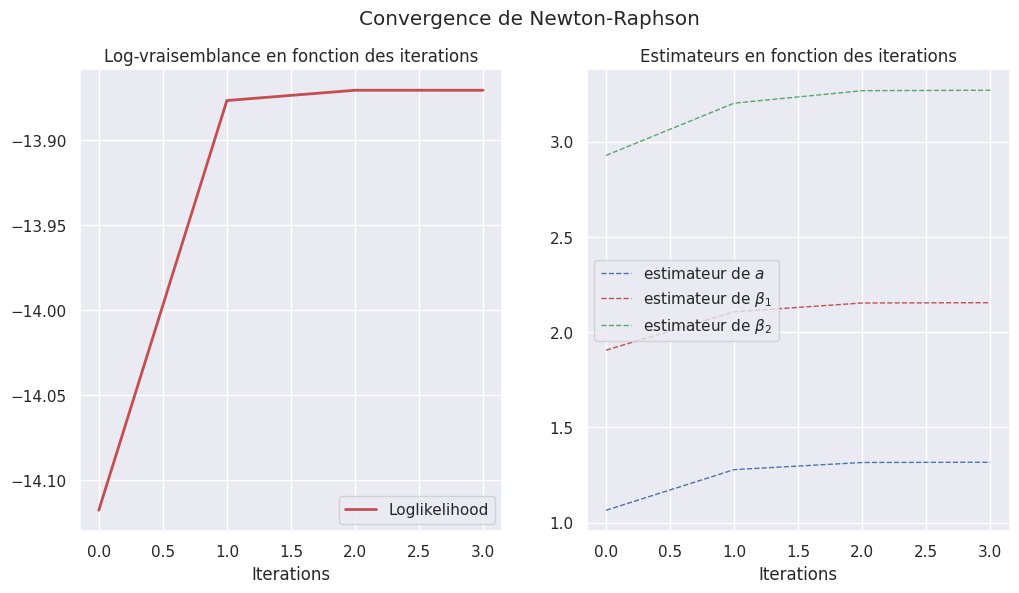

In [17]:
# PLOT OF LOGLIKELIHOOD AND ESTIMATORS VALUES FOR EACH ITERATION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Convergence de Newton-Raphson')

ax1.set_title("Log-vraisemblance en fonction des iterations")
ax1.plot(l_iters_NR, 'r-', lw=2, label = 'Loglikelihood')
ax1.set_xlabel("Iterations")

ax1.legend()

ax2.set_title("Estimateurs en fonction des iterations")
ax2.plot(iters_NR[:,0], 'b--', lw=1, label = fr'estimateur de $a$')
ax2.plot(iters_NR[:,1], 'r--', lw=1, label = fr'estimateur de $\beta_1$')
ax2.plot(iters_NR[:,2], 'g--', lw=1, label = fr'estimateur de $\beta_2$')
ax2.set_xlabel("Iterations")
ax2.legend()

plt.show()

**Remarques** :
- Convergence très rapide (quadratique) en moins de 10 itérations. 
- Dépend fortement du choix de l'initialisation.

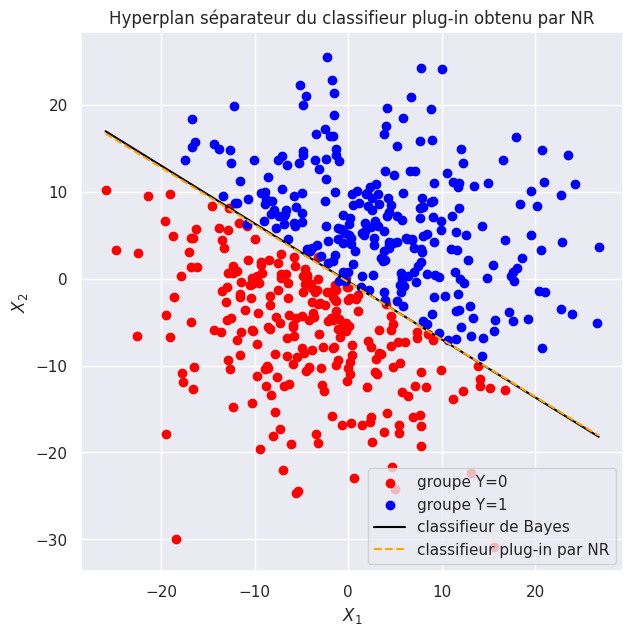

In [18]:
# PLOT OF THE PLUG-IN CLASSIFIER
classif_NR = [hyperplan(x, theta_NR) for x in abscisse]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

ax.scatter(X0[:,0],X0[:,1],label=fr"groupe Y=0", color='red')
ax.scatter(X1[:,0],X1[:,1],label=fr"groupe Y=1", color='blue')
ax.plot(abscisse, classif_bayes, label=fr"classifieur de Bayes", color='black')
ax.plot(abscisse, classif_NR, label=fr"classifieur plug-in par NR", color='orange', linestyle='dashed')
ax.set_xlabel("$X_1$"); ax.set_ylabel("$X_2$")
ax.set_title("Hyperplan séparateur du classifieur plug-in obtenu par NR")

ax.legend()
plt.show()

In [19]:
# VALID PREDICTIONS PROPORTION
nb_tests = 1000
mean = test(nb_tests, theta_NR, theta)
print("Mean of successful predictions over ", nb_tests, " tests : ", mean)

Mean of successful predictions over  1000  tests :  0.981


## 2.3. Exemple non logistique</font><a id='eg'></a>

Certaines lois ne conviennent pas à l'hypothèse logistique. Ici tout fonctionne bien car comme on l'a dit, on a généré des $Y_i$ à partir des $X_i$ et des vrais paramètres **selon le cadre logistique**. On imagine facilement des données qui ne peuvent être séparées par un hyperplan, par exemple en 2 dimensions : un groupe de points "encerclé" par les points d'un deuxième groupe.

Faisons le test de maximiser la vraisemblance par montée de gradient :

In [24]:
# GENERATING DATA
X_eg = np.random.normal(0,1,(d,size))
Y_eg = np.zeros(size)
X0_eg = []
X1_eg = []
for i in range(size):
    if X_eg[0,i]**2+X_eg[1,i]**2 >= 1:
        Y_eg[i]=1
        X1_eg.append(X_eg[:,i])
    else:
        X0_eg.append(X_eg[:,i])

X0_eg = np.reshape(X0_eg, (len(X0_eg),d))
X1_eg = np.reshape(X1_eg, (len(X1_eg),d))

In [25]:
# RESULT OF THE GRADIENT METHOD
loglikelihood_eg = get_loglikelihood(X_eg,Y_eg)
x0_grad_eg = np.array([0., 0., 0.])
rho_grad_eg = 0.001 # step
eps_grad_eg = 0.01 # precision
Nmax_grad_eg = 10000 # max of iteration

theta_eg, nb_iters_eg, cv_eg, iters_eg, l_iters_eg = gradient_met(loglikelihood_eg, 
                                                            x0_grad_eg, rho_grad_eg, eps_grad_eg, Nmax_grad_eg)

print("----- Return values of gradient method -----")
print("The maximum of loglikelihood found is ", theta_eg)
print("Found in ", nb_iters_eg, " iterations")
print("Did the method converge ? ", cv_eg)

----- Return values of gradient method -----
The maximum of loglikelihood found is  [ 0.31760655  0.02702525 -0.06709584]
Found in  66  iterations
Did the method converge ?  True


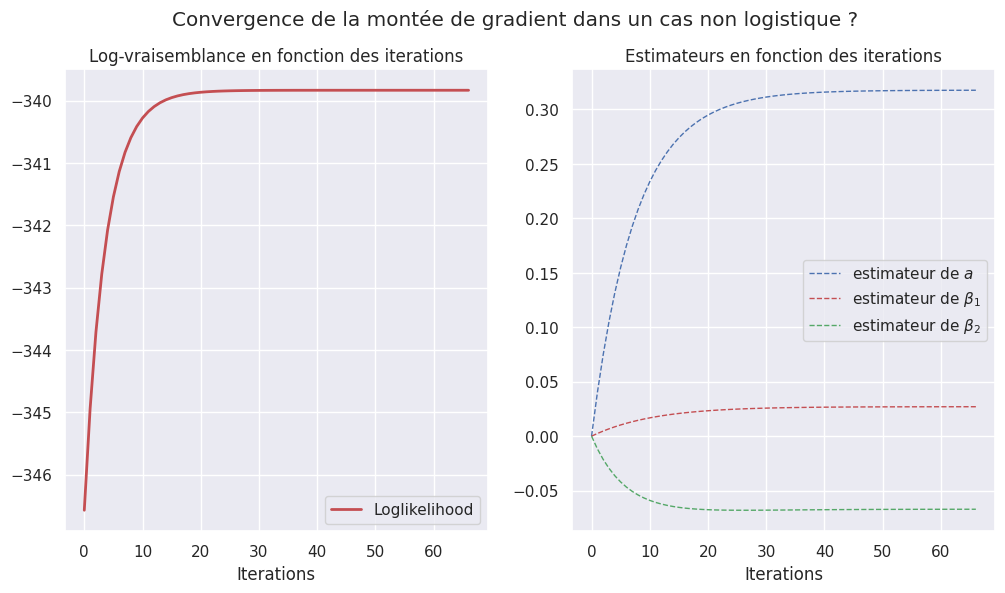

In [26]:
# PLOT OF LOGLIKELIHOOD AND ESTIMATORS VALUES FOR EACH ITERATION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Convergence de la montée de gradient dans un cas non logistique ?')

ax1.set_title("Log-vraisemblance en fonction des iterations")
ax1.plot(l_iters_eg, 'r-', lw=2, label = 'Loglikelihood');
ax1.set_xlabel("Iterations")
ax1.legend()

ax2.plot(iters_eg[:,0], 'b--', lw=1, label = fr'estimateur de $a$');
ax2.plot(iters_eg[:,1], 'r--', lw=1, label = fr'estimateur de $\beta_1$');
ax2.plot(iters_eg[:,2], 'g--', lw=1, label = fr'estimateur de $\beta_2$');
ax2.set_title('Estimateurs en fonction des iterations')
ax2.set_xlabel("Iterations")
ax2.legend()

plt.show()

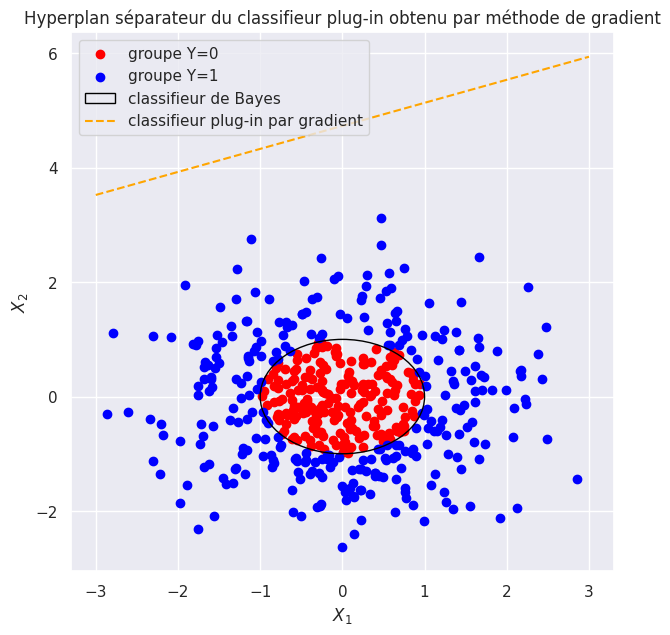

In [27]:
# PLOT OF THE PLUG-IN CLASSIFIER
abscisse_eg = np.linspace(-3,3,5)
classif_eg = [hyperplan(x, theta_eg) for x in abscisse_eg]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

ax.scatter(X0_eg[:,0],X0_eg[:,1],label=fr"groupe Y=0", color='red')
ax.scatter(X1_eg[:,0],X1_eg[:,1],label=fr"groupe Y=1", color='blue')
circle = plt.Circle((0., 0.), 1, color='black', fill=False, label="classifieur de Bayes")
ax.add_artist(circle)
ax.plot(abscisse_eg, classif_eg, label=fr"classifieur plug-in par gradient", color='orange', linestyle='dashed')

ax.set_xlabel("$X_1$"); ax.set_ylabel("$X_2$")
ax.set_title("Hyperplan séparateur du classifieur plug-in obtenu par méthode de gradient")

ax.legend()
plt.show()

**C'est un échec !**

# <font color=darkgreen>3. Conclusion et ouvertures</font></font><a id='conclusion'></a>

- La méthode de gradient à pas fixe converge linéairement, ce qui est relativement lent. De plus, son théorème de convergence demande que l'image du point initial ne soit pas trop éloignée de l'image de la solution. On constate, expérimentalement pour le moment, que cette condition est moins forte que la condition de convergence de Newton-Raphson.
- La méthode de Newton-Raphson converge de manière quadratique. Elle est donc beaucoup plus rapide que la méthode de gradient à pas fixe. En revanche, pour que son théorème de convergence s'applique, il faut initialiser la méthode proche de la solution (différent du fait que leurs images soient proches l'une de l'autre...). Aussi, pour trouver un minimum (resp. maximum) d'une fonction $f$ à l'aide de cette méthode, il faut non seulement approcher le $x^*$ tel que $df(x^*) = 0$ mais aussi vérifier que $d^2f(x^*)$ est définie positive (resp. définie négative).

Il faut cependant remarquer que dans le but que nos exemples convergent nous avons choisi,

pour le gradient :
- Initialisation à $x_0 = (a,\beta_1, \dots, \beta_d) + \mathcal{U}([-10,10])^{d+1}$ relativement loin des vrais paramètres
- Un pas de 0.001 qui est plutôt petit
- Une précision $\varepsilon = 1$ qui est plutôt grande

pour Newton-Raphson :
- Initialisation à $x_0 = (a,\beta_1, \dots, \beta_d) + \mathcal{U}([-0.1,0.1])^{d+1}$ très proche des vrais paramètres
- Une précision $\varepsilon = 0.0001$ qui est petite

**Ouvertures** :
- Dans la méthode de gradient, au lieu d'un pas fixe, utiliser un pas $\rho_k$ adaptatif.
- Méthode de gradient par batch.
- Méthode de gradient stochastique.
- Si $Y$ est à valeurs dans $\left\{1,\dots,K\right\}, K \in \mathbb{N}$, utiliser la fonction `softmax`.